# Comparing BDT and NN Statistics

In [2]:
import pickle
import numpy as np
import pandas as pd
import torch as th
from matplotlib import pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, f1_score
from nn_classes import *
import utils;

### Load the Data

In [72]:
dilept = np.load("test_sets/ttH_hadT_bkgd2_test.npy")
semilept1 = np.load("test_sets/ttH_hadT_signal_test.npy")
#semi_bkgd = np.load("test_sets/all_testing_basic_set.npy")
test = np.load("test_sets/all_testing_basic_set.npy")
bkgd_testset = utils.CollisionDataset(dilept[:, :31])
sig_testset = utils.CollisionDataset(semilept1[:, :31])
#bkgd_testset2 = utils.CollisionDataset(semi_bkgd)
testset = utils.CollisionDataset(test)
bkgd_testset.load_scaler("data_standardizer_all.npz")
sig_testset.load_scaler("data_standardizer_all.npz")
#bkgd_testset2.load_scaler("data_standardizer_all.npz")
testset.load_scaler("data_standardizer_all.npz")
#bkgd_testset2.subsample(0.2)
testset.subsample(0.1)

### Load the BDTs

In [22]:
with open("bdt.pkl", 'rb') as f:
    bdt = pickle.load(f)
with open("bdt_eng5.pkl", 'rb') as f:
    bdt5 = pickle.load(f)
with open("basic_bdt.pkl", 'rb') as f: 
    bdt_basic = pickle.load(f)

### Load the Neural Nets

In [50]:
input_dim = bkgd_testset._tX.size()[1]

net = DHTTNet(input_dim)

net.load_state_dict(th.load("neural_net.pth"))

## Make Predictions/Discriminants

In [23]:
bdt_predicted = bdt.predict(test_X)
bdt_decision = bdt.decision_function(test_X)

bdt5_predicted = bdt5.predict(test5_X)
bdt5_decision = bdt5.decision_function(test5_X)

bdt_basic_predicted = bdt_basic.predict(raw_test_X)
bdt_basic_decision = bdt_basic.decision_function(raw_test_X)

In [58]:
X, y = sig_testset[:]
X = Variable(X).float()

In [59]:
sig_discriminant = net(X).data
sig_predicted = th.round(sig_discriminant).long()

In [60]:
X, y = bkgd_testset[:]
X = Variable(X).float()

In [61]:
bkgd_discriminant = net(X).data
bkgd_predicted = th.round(bkgd_discriminant).long()

In [73]:
X, y = testset[:]
X = Variable(X).float()

In [74]:
test_discriminant = net(X).data
test_predicted = th.round(test_discriminant).long()

## Generate Summary Statistics
Summary statistics will be calculated using the best cut for each model.
- Precision: The percent of predicted signal that are actually signal (prediction efficiency).
- Recall: The percent of actualy signal that is predicted signal (what percent of signal was identified).

In [8]:
print("\n\nOptimized Deep Neural Net: Basic Features")
print_stats(deep_reg_discriminant, np_raw_nn_testy)



Optimized Deep Neural Net: Basic Features
             precision    recall  f1-score   support

          0       0.86      0.72      0.78    106365
          1       0.76      0.88      0.82    106365

avg / total       0.81      0.80      0.80    212730

Area Under Curve: 0.889614968077


In [24]:
print("BDT: All Features")
print_stats(bdt_decision, test_y)
print("\n\nBDT: 5 Eng Features")
print_stats(bdt5_decision, test5_y)
print("\n\nBDT: Basic Features")
print_stats(bdt_basic_decision, raw_test_y)

BDT: All Features
             precision    recall  f1-score   support

          0       0.85      0.76      0.80     85092
          1       0.78      0.87      0.82     85092

avg / total       0.82      0.81      0.81    170184

Area Under Curve: 0.898582290709


BDT: 5 Eng Features
             precision    recall  f1-score   support

          0       0.83      0.73      0.78     85092
          1       0.76      0.85      0.80     85092

avg / total       0.80      0.79      0.79    170184

Area Under Curve: 0.8769843106


BDT: Basic Features
             precision    recall  f1-score   support

          0       0.76      0.56      0.64     85092
          1       0.65      0.82      0.72     85092

avg / total       0.70      0.69      0.68    170184

Area Under Curve: 0.781664676878


/home/drnevich/miniconda3/envs/ROOT/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Generate ROC Curves

In [12]:
def overlay_roc_curves(experiments, title=""):
    fig, ax = plt.subplots()
    for exp in experiments:
        roc_points = roc_curve(exp['targets'], exp['discriminant'])
        plt.plot(roc_points[0], roc_points[1], label=exp.get("label"))
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    ax.set_title("ROC Curves {}".format(title))
    plt.legend(loc='lower right')
    fig.set_size_inches(18, 10)

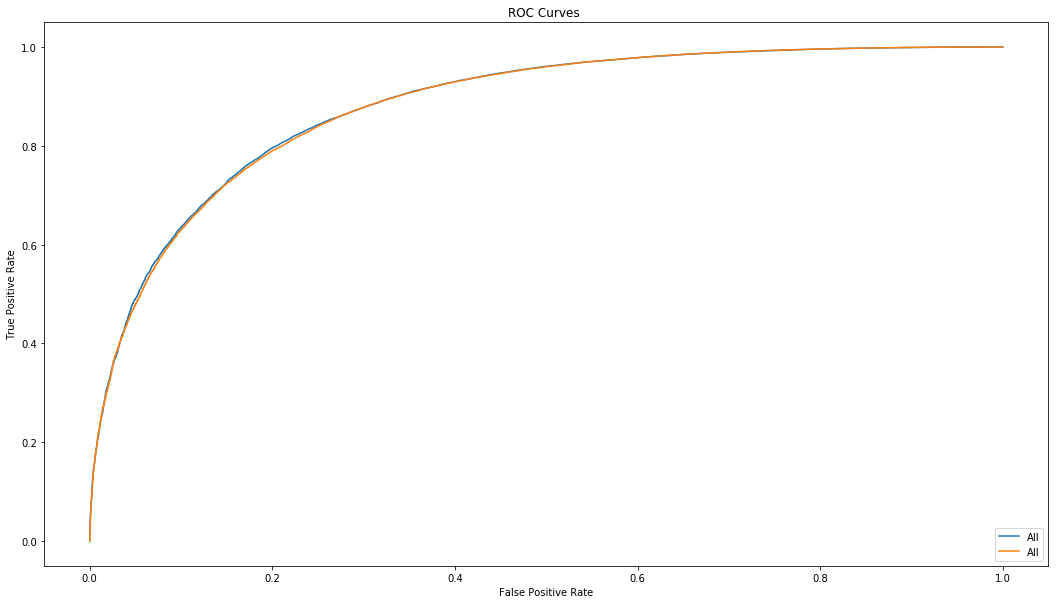

In [38]:
overlay_roc_curves([{'discriminant': bkgd_discriminant2,
                    'targets': bkgd_testset2[:][1].numpy(),
                    'label': "All"},
                   {'discriminant': train_discriminant,
                    'targets': trainset[:][1].numpy(),
                    'label': "All"}])

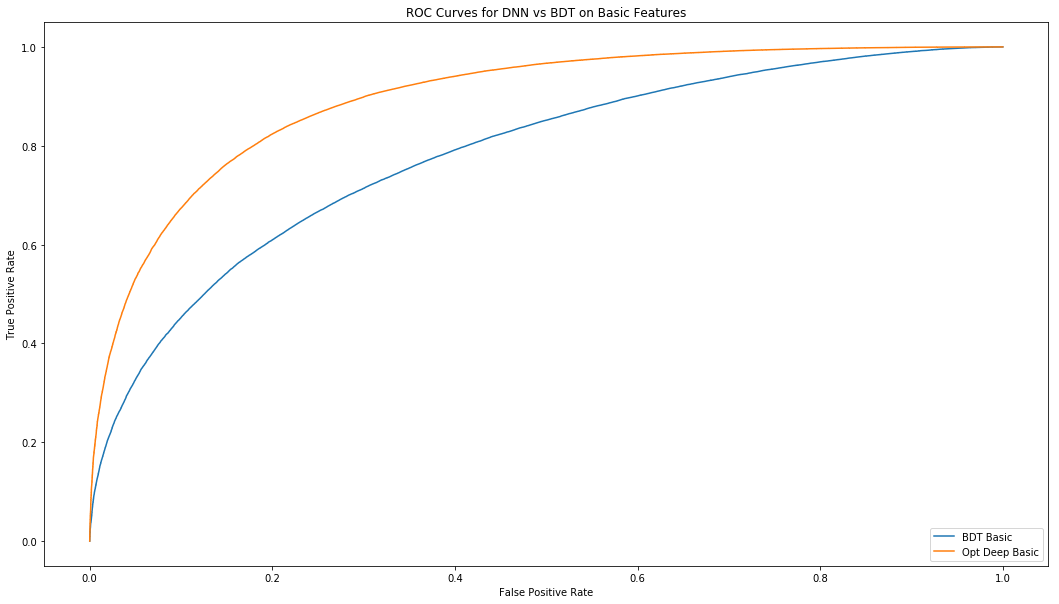

In [26]:
overlay_roc_curves([{'discriminant': bdt_basic_decision,
                    'targets': raw_test_y,
                    'label': "BDT Basic"},
                    {'discriminant': deep_reg_discriminant,
                     'targets': np_raw_nn_testy,
                     'label': "Opt Deep Basic"}], title="DNN vs BDT on Basic Features")

## Plot Distributions

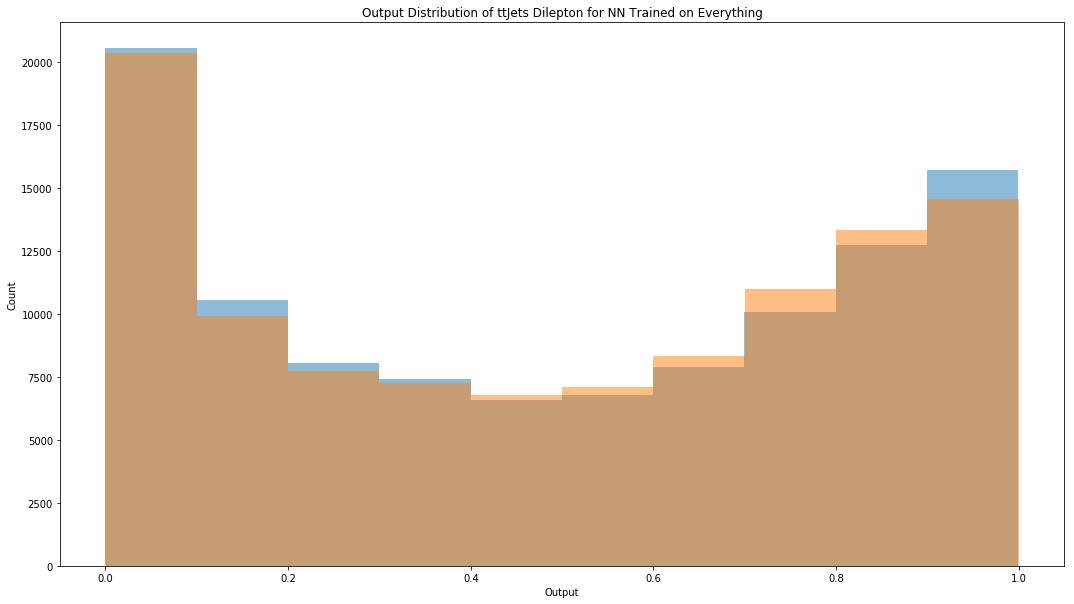

In [64]:
fig, ax = plt.subplots()
plt.hist(bkgd_discriminant.numpy(), alpha=0.5)
plt.hist(sig_discriminant.numpy(), alpha=0.5)
ax.set_ylabel("Count")
ax.set_xlabel("Output")
ax.set_title("Output Distribution of ttJets Dilepton for NN Trained on Everything")
fig.set_size_inches(18, 10)
plt.show()

In [80]:
def plot_distro(experiments, title="NN"):
    fig, ax = plt.subplots()
    for exp in experiments:
        dsignal, dbkgd = exp['discriminant'][(exp['targets'] == 1)], exp['discriminant'][(exp['targets'] == 0)]
    plt.hist(dsignal, alpha=0.5, label="Signal")
    plt.hist(dbkgd, alpha=0.5, label="Background")
    ax.set_ylabel("Count")
    ax.set_xlabel("Output")
    ax.set_title("Output Distribution for {}".format(title))
    plt.legend(loc='lower right')
    fig.set_size_inches(18, 10)

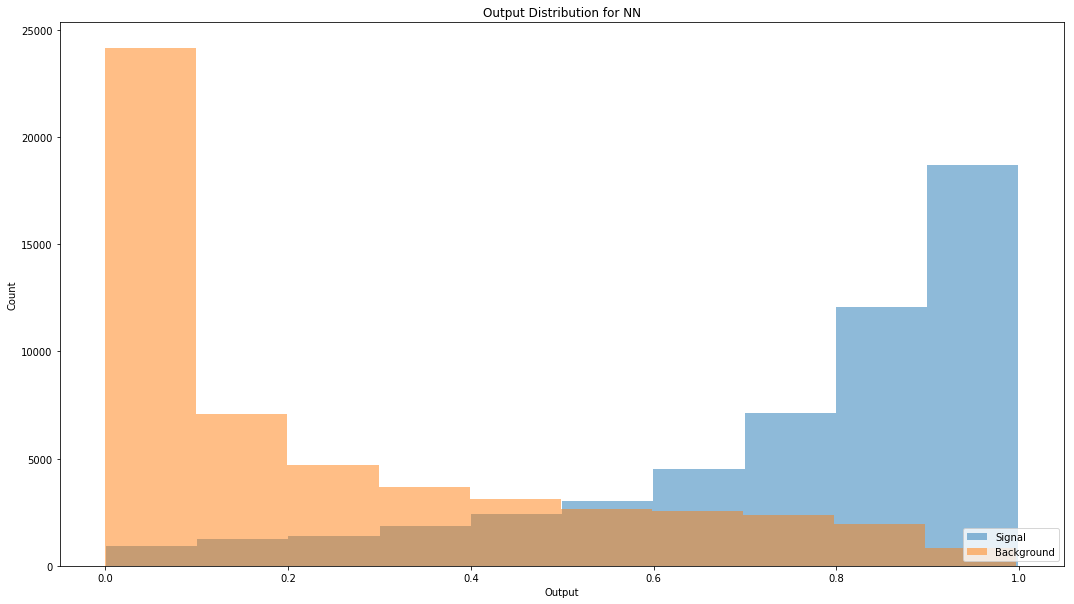

In [81]:
plot_distro([{'discriminant': test_discriminant.numpy(),
                    'targets': testset[:][1].numpy(),
                    'label': "All"}])

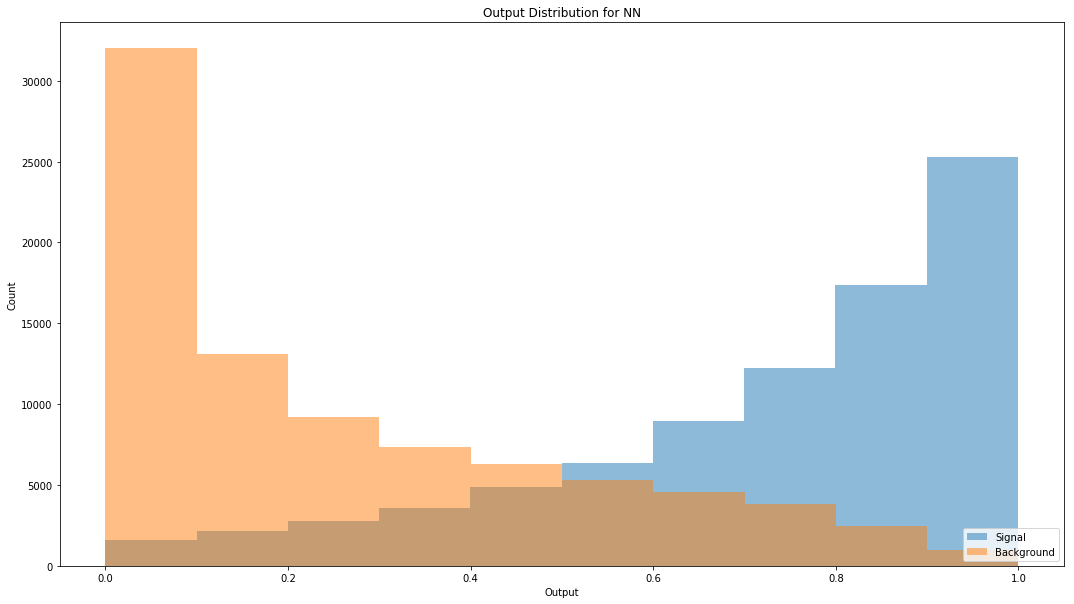

In [12]:
plot_distro([{'discriminant': discriminant,
                    'targets': nn_testy.data.numpy(),
                    'label': "All"}])

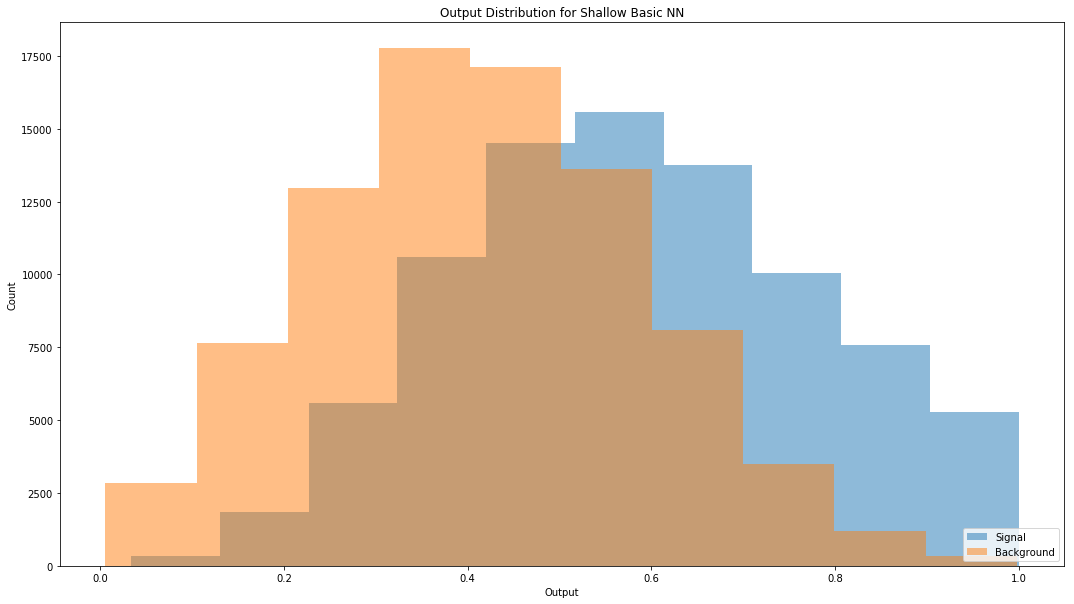

In [13]:
plot_distro([{'discriminant': raw_discriminant,
              'targets': raw_nn_testy.data.numpy(),
              'label': "Basic"}], title="Shallow Basic NN")

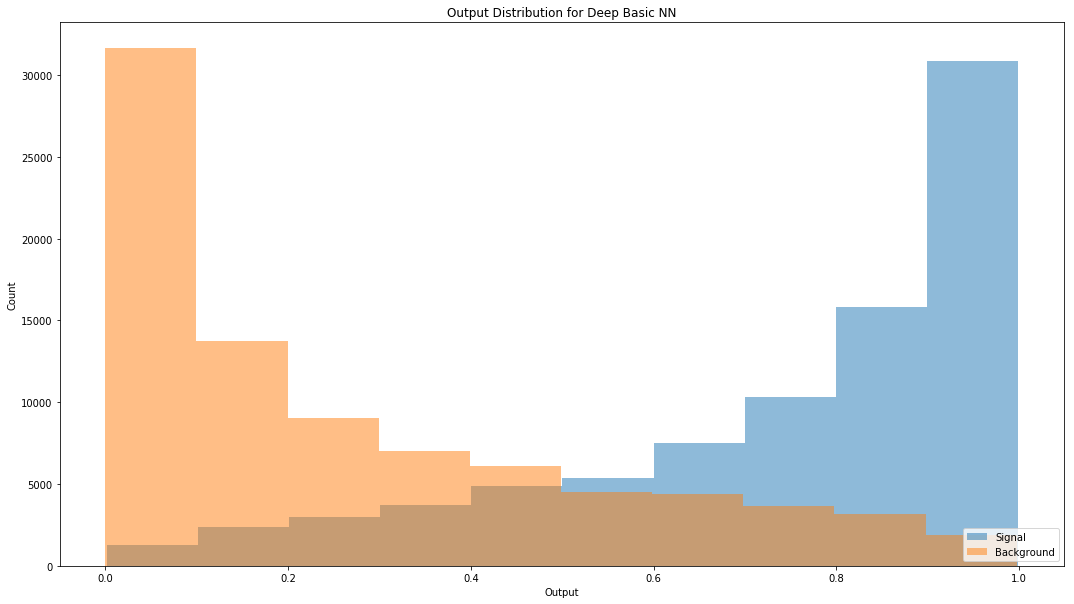

In [14]:
plot_distro([{'discriminant': deep_discriminant,
                     'targets': np_raw_nn_testy,
                     'label': "Deep Basic"}], title="Deep Basic NN")

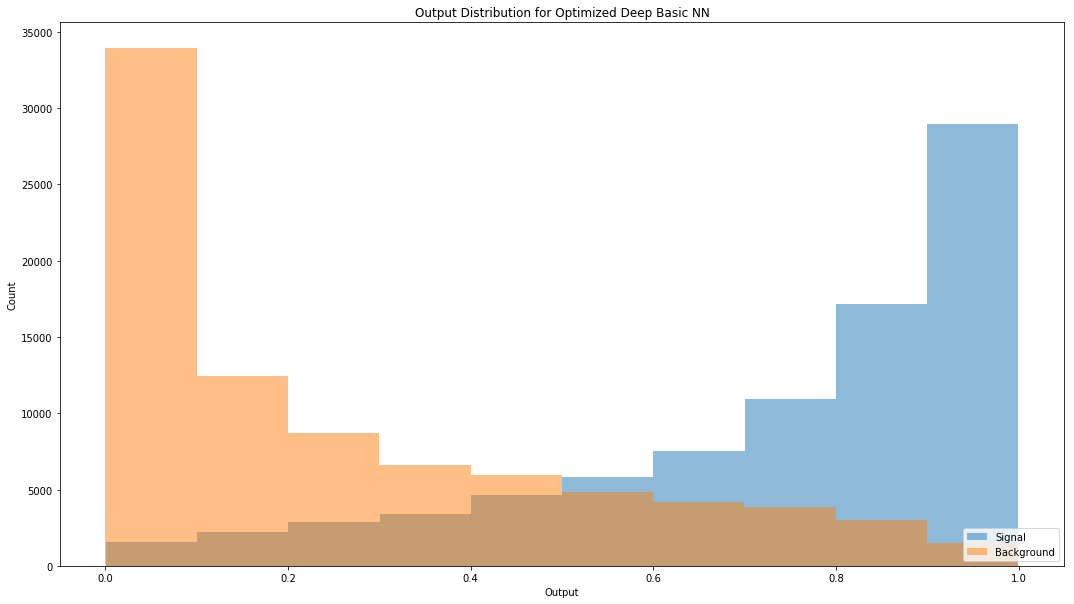

In [16]:
plot_distro([{'discriminant': deep_reg_discriminant,
                     'targets': np_raw_nn_testy,
                     'label': "Opt Deep Basic"}], title="Optimized Deep Basic NN")

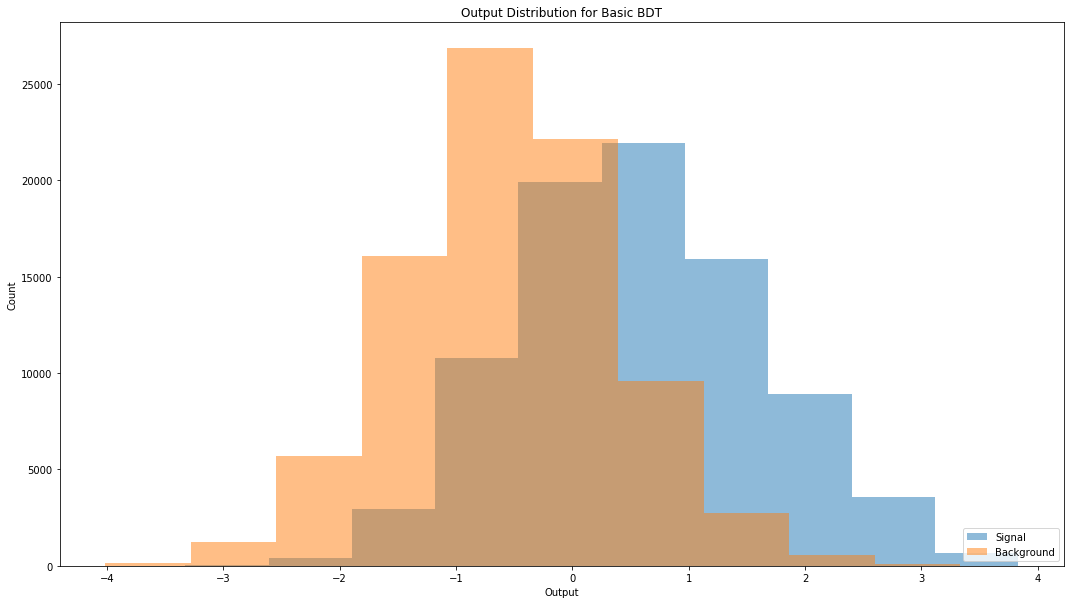

In [27]:
plot_distro([{'discriminant': bdt_basic_decision,
                     'targets': raw_test_y,
                     'label': "Basic BDT"}], title="Basic BDT")

In [75]:
cut = utils.find_cut(net, testset)

In [76]:
utils.print_stats(test_discriminant.numpy(), testset[:][1].numpy())

             precision    recall  f1-score   support

          0       0.87      0.76      0.81     53075
          1       0.79      0.89      0.84     53289

avg / total       0.83      0.82      0.82    106364

Area Under Curve: 0.91006744823


In [78]:
utils.score(net, testset, cut=cut)

0.8250441878831184

In [79]:
cut

0.42969802920429173